In [77]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [83]:
def animate_eig(A,T,filename="myani.gif"):
    """Animates the eigenvalues of the matrix function A(t) 
    over the range of values [t0,t1]
    
    Parameters
    ----------
    A (callable) : depends on a single parameter and returns an (n,n)-ndarray
    T (array-like) : 1d array of values for the independent parameter t
    """
    n = A(T[0]).shape[0]
    E = eig_trajectories(A,T)

    #set up figure
    plt.ioff()
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.axis("off")
    x0,x1 = E.real.min()-1,E.real.max()+1
    y0,y1 = E.imag.min()-1,E.imag.max()+1
    plt.xlim((x0,x1))
    plt.ylim((y0,y1))

    #create line objects
    if n <= 10:
        points = [plt.plot([],[],c=f'C{k}',marker='o')[0] for k in range(n)]
        trajectories = [plt.plot([],[],c=f'C{k}')[0] for k in range(n)]
    else:
        points = [plt.plot([],[],c='C0',marker='o')[0] for k in range(n)]
        trajectories = [plt.plot([],[],c='C0')[0] for k in range(n)]

    #function to update line objects
    def update(i):
        for j in range(n):
            points[j].set_data(E[j,i].real,E[j,i].imag)
            trajectories[j].set_data(E[j,:i+1].real,E[j,:i+1].imag)

    #animation
    ani = animation.FuncAnimation(fig,update,frames=len(T),interval=25)
    ani.save(filename)
    plt.ion()

def eig_trajectories(A,T):
    """Computes the trajectories of the eigenvalues of the 
    matrix function A(t) over the range of values [t0,t1]
    
    Parameters
    ----------
    A (callable) : depends on a single parameter and returns an (n,n)-ndarray
    T (array-like) : 1d array of values for the independent parameter t
    
    Returns
    -------
    E (ndarray) : array of eigenvalue trajectories where E[i] is the 
                    trajectory of the ith eigenvalue as a 1d array
    """
    n,m = A(T[0]).shape
    if n!=m:
        raise ValueError("Matrix must be square")
        
    m = len(T)
    E = np.empty((n,m),dtype="complex")
    E[:,0] = la.eig(A(T[0]),right=False)
    for i,t in enumerate(T[1:]):
        w = la.eig(A(t),right=False)
        mask = list(range(n))
        for eig in w:
            idx = np.argmin(np.abs(eig-E[:,i][mask]))
            E[mask[idx],i+1] = eig
            del mask[idx]
    return E

def eig_loops(A,U,V):
    """Computes the loops of eigenvalues for the matrix function A(u,v)"""
    n = A(U[0],V[0]).shape[0]
    m = len(U)
    l = len(V)
    
    L = np.empty((n,m,l),dtype="complex")
    
    B = lambda u: A(u,V[0])
    L[:,:,0] = eig_trajectories(B,U)
    
    for i,v in enumerate(V[1:]):
        B = lambda u: A(u,v)
        E = eig_trajectories(B,U)
        mask = list(range(n))
        for traj in E:
            idx = np.argmin(np.abs(traj[0]-L[:,0,i][mask]))
            L[mask[idx],:,i+1] = traj
            del mask[idx]
    return L

def animate_eig_loops(A,U,V,filename):
    n = A(U[0],V[0]).shape[0]
    L = eig_loops(A,U,V)

    #set up figure
    plt.ioff()
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.axis("off")
    x0,x1 = L.real.min()-1,L.real.max()+1
    y0,y1 = L.imag.min()-1,L.imag.max()+1
    plt.xlim((x0,x1))
    plt.ylim((y0,y1))

    #create line objects
    trajectories = [plt.plot([],[],c='C0')[0] for k in range(n)]

    #function to update line objects
    def update(i):
        for j in range(n):
            trajectories[j].set_data(L[j,:,i].real,L[j,:,i].imag)

    #animation
    ani = animation.FuncAnimation(fig,update,frames=len(T),interval=25)
    ani.save(filename)
    plt.ion()
    
def eigenvector_trajectories(A,T):
    n = A(T[0]).shape[0]
    m = len(T)
    E = np.empty((n,m),dtype="complex")
    V = np.empty((n,n,m),dtype="complex")
    E[:,0], V[:,:,0] = la.eig(A(T[0]))
    for i,t in enumerate(T[1:]):
        w,v = la.eig(A(t))
        mask = list(range(n))
        for eig in w:
            idx = np.argmin(np.abs(eig-E[:,i][mask]))
            E[mask[idx],i+1] = eig
            V[:,mask[idx],i+1] = v[:,mask[idx]]*np.sign(v[:,mask[idx]]@V[:,mask[idx],i])
            del mask[idx]
    return E,V
    
def animate_eigenvectors_2d(A,T,filename):
    n = A(T[0]).shape[0]
    if n != 2:
        raise ValueError("Maxtrix must be 2-by-2")
    E,V = eigenvector_trajectories(A,T)

    #set up figure
    plt.ioff()
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    rvec = [ax1.plot([],[],c=f'C{i}',label=f'Eigenvector {i}')[0] for i in range(2)]
    plt.title('Eigenvector real part')
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlim([-1,1])
    ax2.set_ylim([-1,1])
    ivec = [ax2.plot([],[],c=f'C{i}',label=f'Eigenvector {i}')[0] for i in range(2)]
    plt.title('Eigenvector imaginary part')
    ax3 = fig.add_subplot(1,3,3)
    x0,x1 = E.real.min()-1,E.real.max()+1
    y0,y1 = E.imag.min()-1,E.imag.max()+1
    ax3.set_xlim((x0,x1))
    ax3.set_ylim((y0,y1))
    eig = [ax3.plot([],[],c=f'C{i}',marker='o',label=f'Eigenvalue {i}')[0] for i in range(2)]
    plt.legend()

    #function to update line objects
    def update(i):
        for j in range(n):
            rvec[j].set_data([0,V[0,j,i].real],[0,V[1,j,i].real])
            ivec[j].set_data([0,V[0,j,i].imag],[0,V[1,j,i].imag])
            eig[j].set_data(E[j,i].real,E[j,i].imag)

    #animation
    ani = animation.FuncAnimation(fig,update,frames=len(T),interval=25)
    ani.save(filename)
    plt.ion()

In [5]:
U = 10*np.random.rand(20,20)-5
V = 10*np.random.rand(20,20)-5

A = lambda t: U + np.exp(2*np.pi*1j*t)*V
T = np.linspace(0,1,1000)
#animate_eig(A,T,"ani2.mp4")

In [88]:
n = 100
M1 = np.random.randn(n,n)+1j*np.random.randn(n,n)
M2 = np.random.randn(n,n)+1j*np.random.randn(n,n)
M3 = np.random.randn(n,n)+1j*np.random.randn(n,n)

In [89]:
T = np.linspace(0,1,300)

A = lambda s,t: (M1 + .1*np.exp(2*np.pi*1j*s)*M2 + .1*np.exp(2*np.pi*1j*t)*M3)**2
#L = eig_loops(A,T,T)

In [80]:
fig = plt.figure()
for i in range(n):
    plt.plot(L[i,0,0].real,L[i,0,0].imag,marker='o',c=f"C{i}")
    plt.plot(L[i,:,0].real,L[i,:,0].imag,c=f"C{i}")
plt.show()

IndexError: index 10 is out of bounds for axis 0 with size 10

<IPython.core.display.Javascript object>


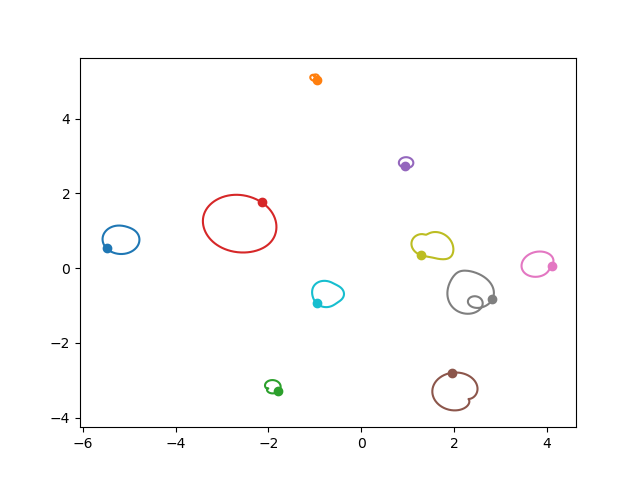

In [61]:
fig = plt.figure()
for i in range(n):
    plt.plot(L[i,0,1].real,L[i,0,1].imag,marker='o',c=f"C{i}")
    plt.plot(L[i,:,1].real,L[i,:,1].imag,c=f"C{i}")
plt.show()

In [90]:
animate_eig_loops(A,T,T,filename="loops8.mp4")

In [70]:
A = np.random.randn(10,10)
A = A + A.T
At = lambda t: la.expm(2*np.pi*1j*t*A)

In [71]:
animate_eig(At,T,filename="hermetian.mp4")

In [86]:
M1 = np.random.randn(2,2)+1j*np.random.randn(2,2)
M2 = np.random.randn(2,2)+1j*np.random.randn(2,2)
A = lambda t: M1 + np.exp(2*np.pi*1j*t)*M2

In [87]:
animate_eigenvectors_2d(A,T,"vectors.mp4")